## Improve the state of art in predicting in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# configurations
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

In [222]:
# load train and test files
train = pd.read_csv('../data/raw/cs-training.csv')
test = pd.read_csv('../data/raw/cs-test.csv')

In [223]:
# concatenate train and test
data = pd.concat((train, test), axis=0)

In [14]:
# data dictionary
data_dictionary = pd.read_excel('../data/raw/Data Dictionary.xls')

In [16]:
data_dictionary[['Variable Name', 'Description']].values

array([['SeriousDlqin2yrs',
        'Person experienced 90 days past due delinquency or worse '],
       ['RevolvingUtilizationOfUnsecuredLines',
        'Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits'],
       ['age', 'Age of borrower in years'],
       ['NumberOfTime30-59DaysPastDueNotWorse',
        'Number of times borrower has been 30-59 days past due but no worse in the last 2 years.'],
       ['DebtRatio',
        'Monthly debt payments, alimony,living costs divided by monthy gross income'],
       ['MonthlyIncome', 'Monthly income'],
       ['NumberOfOpenCreditLinesAndLoans',
        'Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)'],
       ['NumberOfTimes90DaysLate',
        'Number of times borrower has been 90 days or more past due.'],
       ['NumberRealEstateLoansOrLines',
        'Number of mortgage and real estat

** SeriousDlqin2yrs is the target variable **

In [11]:
# class count ( class imbalance )
print(data.SeriousDlqin2yrs.value_counts())

0.0    139974
1.0     10026
Name: SeriousDlqin2yrs, dtype: int64


** Very few people experienced financial distress. **

In [7]:
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Distribution of age

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


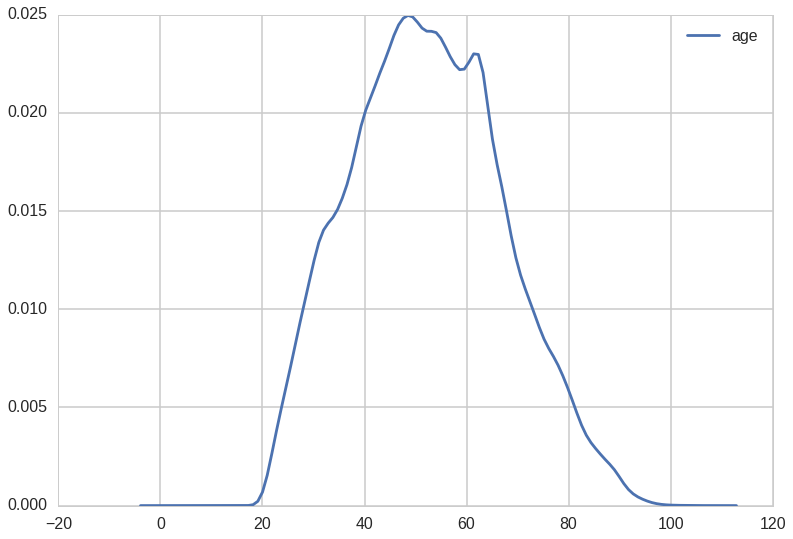

In [17]:
sns.kdeplot(data.age);

In [18]:
data.age.describe()

count    251503.000000
mean         52.339694
std          14.775120
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

** Age with Target Variable **

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


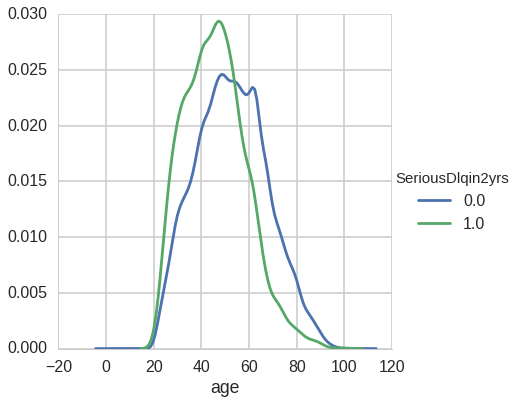

In [20]:
sns.FacetGrid(data, hue='SeriousDlqin2yrs', size=6)\
    .map(sns.kdeplot, 'age')\
    .add_legend();

** As we can see very clearly that age plays a role in determining the stress levels. **

### Distribution of RevolvingUtilizationOfUnsecuredLines

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


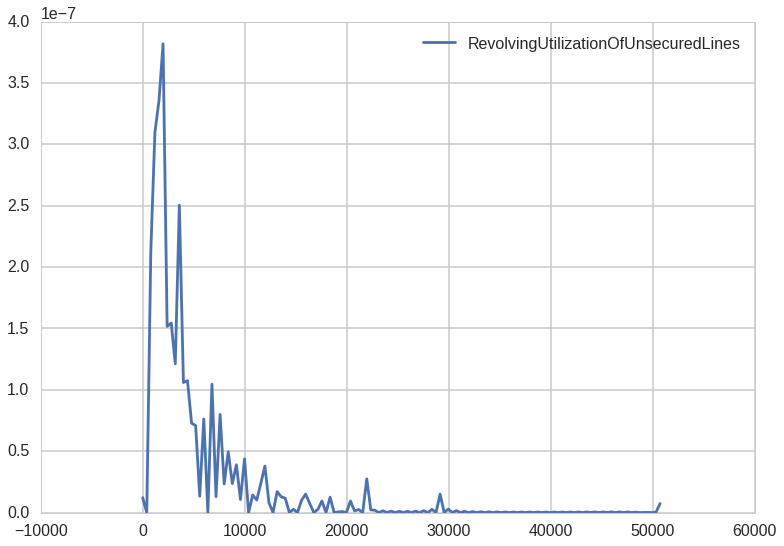

In [144]:
sns.kdeplot(data.RevolvingUtilizationOfUnsecuredLines);

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


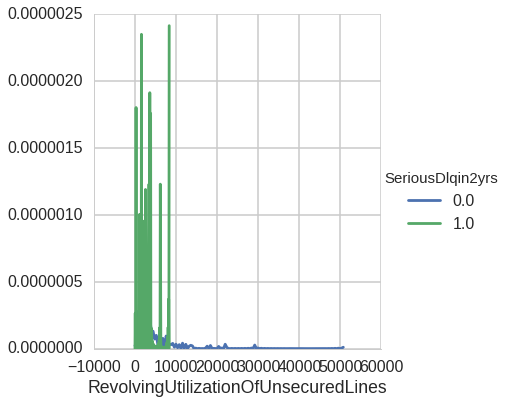

In [152]:
sns.FacetGrid(data, hue='SeriousDlqin2yrs', size=6)\
    .map(sns.kdeplot, 'RevolvingUtilizationOfUnsecuredLines')\
    .add_legend();

In [224]:
data['utilization_levels'] = data.RevolvingUtilizationOfUnsecuredLines.map(lambda x: int(x < 1.0))

train['utilization_levels'] = data.loc[data.SeriousDlqin2yrs.notnull(), 'utilization_levels']
test['utilization_levels'] = data.loc[data.SeriousDlqin2yrs.isnull(), 'utilization_levels']

** Number of times borrower has been 90 days or more past due. **

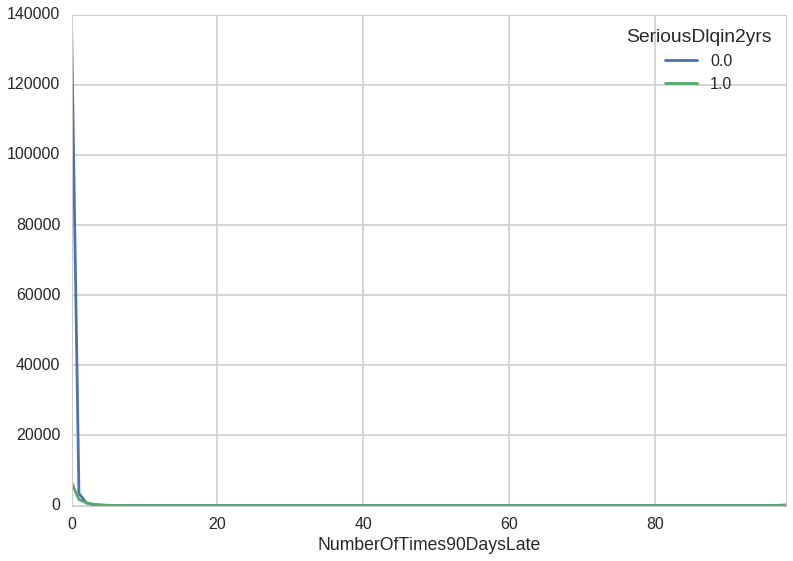

In [175]:
data.groupby(['NumberOfTimes90DaysLate', 'SeriousDlqin2yrs']).size().unstack(1).fillna(0).plot();

### Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

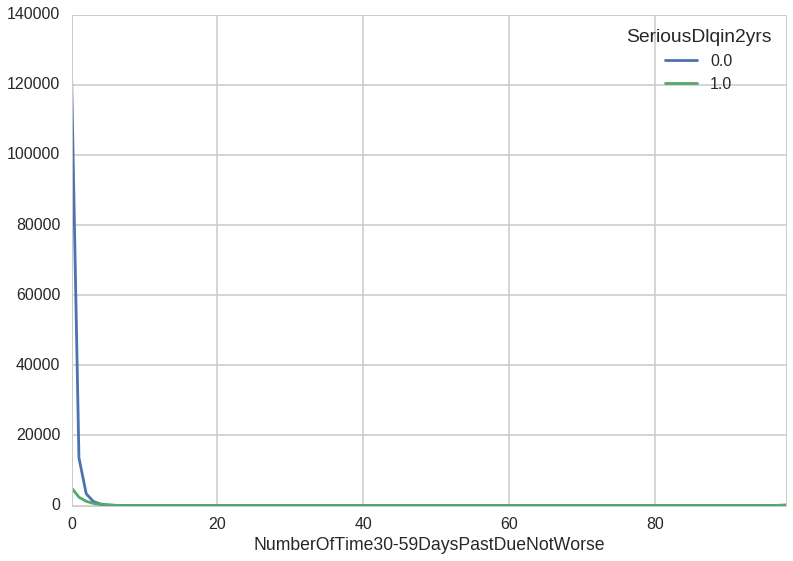

In [177]:
data.groupby(['NumberOfTime30-59DaysPastDueNotWorse', 'SeriousDlqin2yrs']).size().unstack(1).fillna(0).plot();

### Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

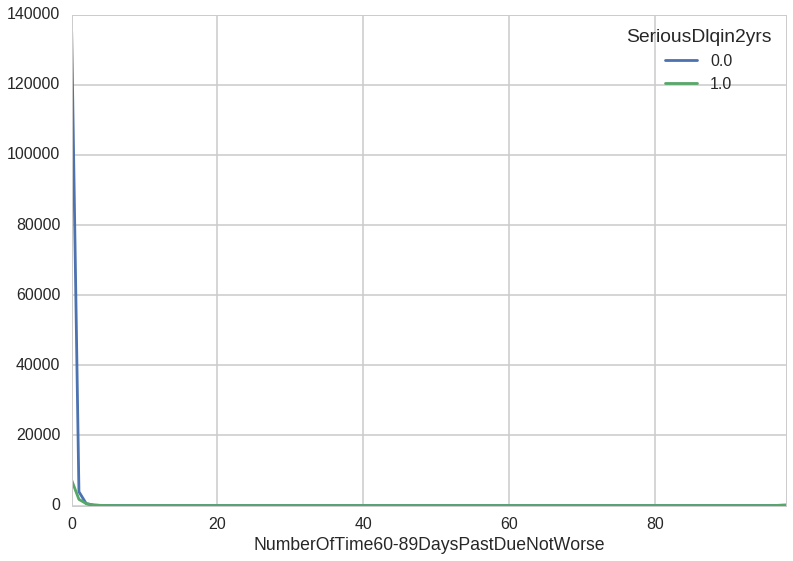

In [179]:
data.groupby(['NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs']).size().unstack(1).fillna(0).plot();

### Debt Ratio

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


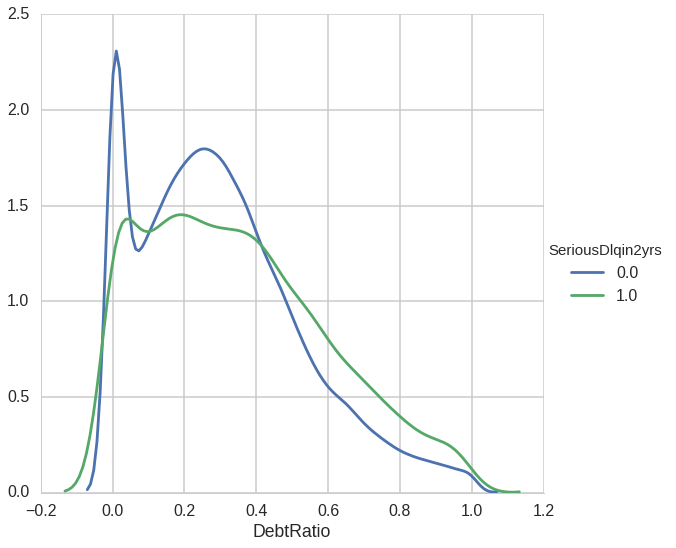

In [206]:
sns.FacetGrid(data.loc[data.DebtRatio <= 1.], hue='SeriousDlqin2yrs', size=8)\
    .map(sns.kdeplot, 'DebtRatio')\
    .add_legend();

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


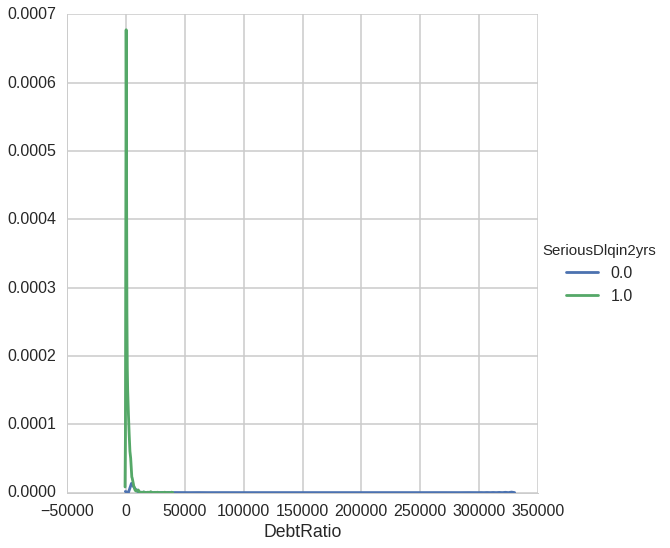

In [207]:
sns.FacetGrid(data.loc[data.DebtRatio > 1.], hue='SeriousDlqin2yrs', size=8)\
    .map(sns.kdeplot, 'DebtRatio')\
    .add_legend();

In [226]:
def create_debt_ratio_level(debt_ratio):
    if debt_ratio <= 0.5:
        return 'under 0.5'
    elif debt_ratio > 0.5 and debt_ratio <= 1.0:
        return 'between 0.5 and 1.0'
    else:
        return 'above 1.0'
    
data['debt_ratio_levels'] = data.DebtRatio.map(create_debt_ratio_level)
train['debt_ratio_levels'] = data.loc[data.SeriousDlqin2yrs.notnull(), 'debt_ratio_levels']
test['debt_ratio_levels'] = data.loc[data.SeriousDlqin2yrs.isnull(), 'debt_ratio_levels']

### Monthly Income

In [244]:
data['is_missing_income_null'] = data.MonthlyIncome.map(lambda x: int(pd.isnull(x)))
train['is_missing_income_null'] = data.loc[data.SeriousDlqin2yrs.notnull(), 'is_missing_income_null']
test['is_missing_income_null'] = data.loc[data.SeriousDlqin2yrs.isnull(), 'is_missing_income_null']

In [255]:
data.MonthlyIncome.fillna(data.loc[data.MonthlyIncome.notnull(), 'MonthlyIncome'].median(), inplace=True)
train['MonthlyIncome'] = data.loc[data.SeriousDlqin2yrs.notnull(), 'MonthlyIncome']
test['MonthlyIncome'] = data.loc[data.SeriousDlqin2yrs.isnull(), 'MonthlyIncome']

In [256]:
data.MonthlyIncome.describe()

count    2.515030e+05
mean     6.478350e+03
std      2.303541e+04
min      0.000000e+00
25%      3.900000e+03
50%      5.400000e+03
75%      7.385000e+03
max      7.727000e+06
Name: MonthlyIncome, dtype: float64

In [ ]:
def create_income_levels(monthly_income):
    if monthly_income < 2e4:
        return 'low income'
    elif monthly_income >= 2e4 and monthly_income < 9e4:
        return 'medium income'
    else:
        return 'hight income'

data['monthly_income_levels'] = data.MonthlyIncome.map(create_income_levels)
train['monthly_income_levels'] = data.loc[data.SeriousDlqin2yrs.notnull(), 'mont']

/home/abhishek/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


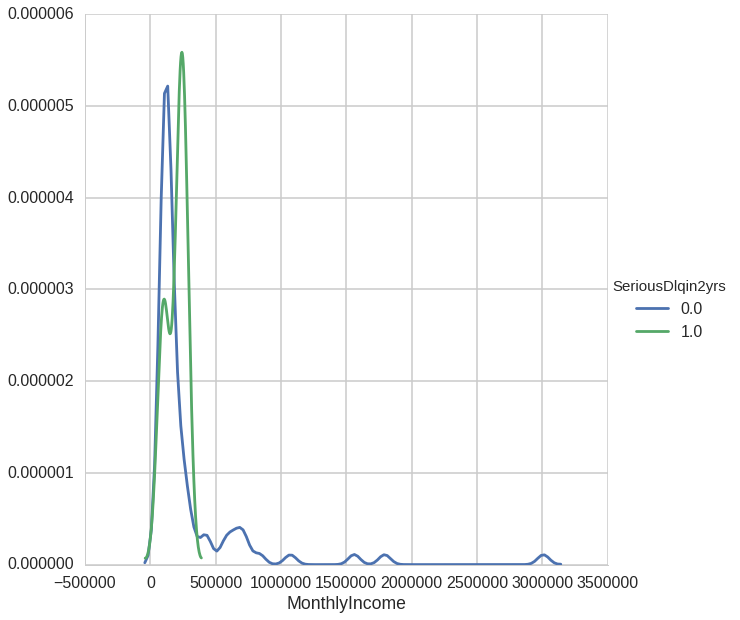

In [252]:
sns.FacetGrid(data.loc[data.MonthlyIncome > 9e4, ['MonthlyIncome', 'SeriousDlqin2yrs']], hue='SeriousDlqin2yrs', size=9)\
    .map(sns.kdeplot, 'MonthlyIncome')\
    .add_legend();

### Plot decision boundaries

In [154]:
# color pallettes
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

In [155]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm = plt.cm.RdBu


def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    
    h = .02
    X = np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    ZZ = Z.reshape(xx.shape)
    
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    return ax,xx,yy

In [156]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    
    return ax 

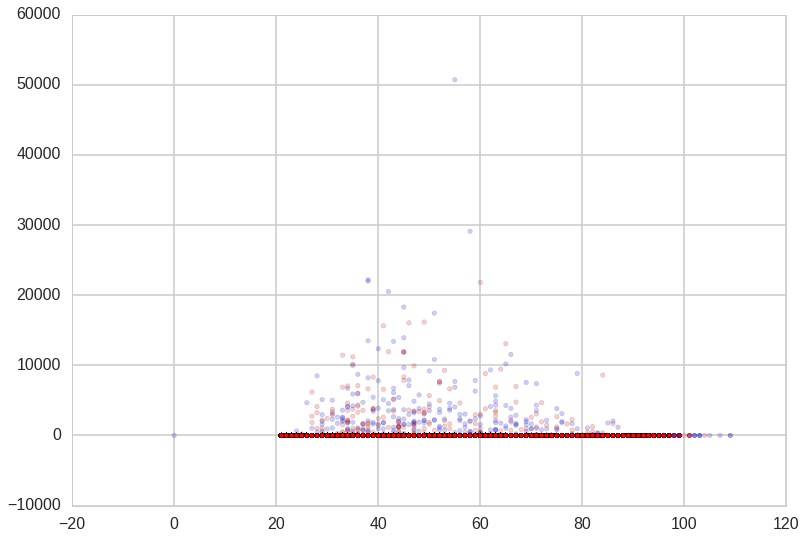

In [30]:
plt.scatter(data['age'], data['RevolvingUtilizationOfUnsecuredLines'], \
            c=[cm_bright.colors[i] for i in data.SeriousDlqin2yrs==0], alpha=0.2);

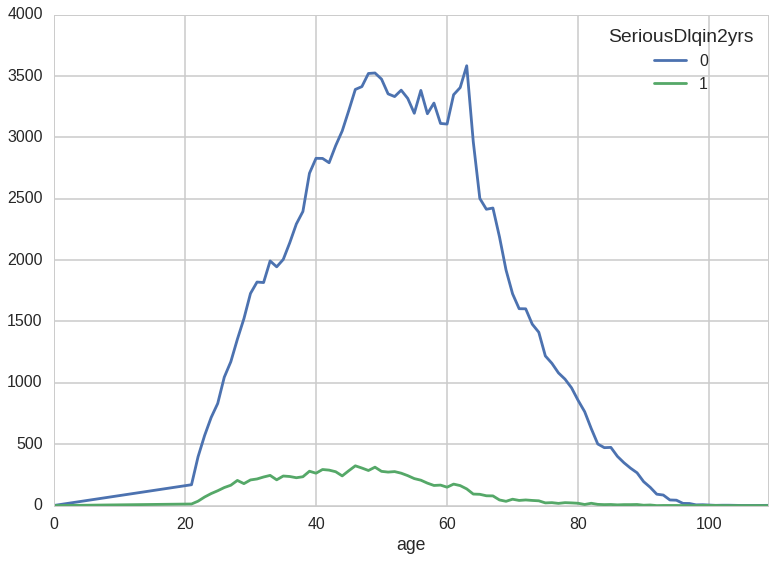

In [88]:
train.groupby(['age', 'SeriousDlqin2yrs']).size().unstack(1).fillna(0).plot();

In [227]:
def create_age_levels(age):
    if age >= 0 and age < 18:
        return 'under 18'
    elif age >= 18 and age < 40:
        return 'between 18 and 40'
    elif age >= 40 and age < 65:
        return 'between 40 and 65'
    else:
        return 'above 65'
    
data['age_levels'] = data.age.map(create_age_levels)
train['age_levels'] = data.loc[data.SeriousDlqin2yrs.notnull(), 'age_levels']
test['age_levels'] = data.loc[data.SeriousDlqin2yrs.isnull(), 'age_levels']

In [228]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()

for feat in ['age_levels', 'debt_ratio_levels']:
    lbl.fit(data[feat])

    train[feat] = lbl.transform(train[feat])
    test[feat] = lbl.transform(test[feat])

In [229]:
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, roc_auc_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    
    for train, test in StratifiedKFold(y, nfold, shuffle=True):
        clf.fit(x[train], y[train])
        
        if score_func == roc_auc_score:
            result += score_func(y[test], clf.predict_proba(x[test])[:, 1])
        else:
            result += score_func(y[test], clf.predict(x[test]))
    
    return result / nfold

In [232]:
from sklearn.cross_validation import train_test_split

features = ['age', 'utilization_levels', \
            'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', \
            'debt_ratio_levels']

Xlr, Xtestlr, ylr, ytestlr = train_test_split(train[features].values, train.SeriousDlqin2yrs.values, stratify=train.SeriousDlqin2yrs.values)

In [233]:
# grid of parameter to search over

# 0.676966613828 1
# 0.684283752883 0.1
# 0.681125296029 10
# 0.685385624997 1 ['age', 'utilization_levels', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse']
# 0.706691247294 0.1 ['age', 'utilization_levels', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse']
# 0.681904310294 0.1 ['age', 'utilization_levels', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
# 0.706188672462 10 ['age', 'utilization_levels', \
#             'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', \
#             'DebtRatio']
# 0.710441955383 100 ['age', 'utilization_levels', \
#             'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', \
#             'debt_ratio_levels']

from sklearn.linear_model import LogisticRegression

max_score = 0
Cs = [0.001, 0.1, 1, 10, 100]

for C in Cs:
    clf = LogisticRegression(C=C)
    score = cv_score(clf, Xlr, ylr, roc_auc_score)
    
    if score > max_score:
        max_score = score
        best_C = C

print(max_score, best_C)

0.710441955383 100


In [197]:
clfl=LogisticRegression(C=best_C)
clfl.fit(Xlr, ylr)
ypred=clfl.predict_proba(Xtestlr)[:, 1]
print('AUC score on test set: %f'%(roc_auc_score(ytestlr, ypred)))

AUC score on test set: 0.685269
